### BloomTech Data Science


---

# Model Interpretation

- Visualize and interpret **partial dependence plots**
- Explain individual predictions with **shapley value plots**


In [2]:
# !pip install category_encoders
# !pip install pdpbox
# !pip install shap

In [3]:
# import pandas as pd
# from sklearn.linear_model import Ridge,LinearRegression
# from sklearn.ensemble import RandomForestRegressor
# from xgboost import XGBRegressor
# from sklearn.metrics import mean_absolute_error, r2_score
# import matplotlib.pyplot as plt
# from pdpbox.pdp import PDPIsolate, PDPInteract
# from pdpbox.info_plots import TargetPlot, InteractTargetPlot
# import shap
# import warnings

In [4]:
# pdp_isolate = PDPIsolate
# pdp_plot = TargetPlot
# pdp_interact = PDPInteract
# pdp_interact_plot = InteractTargetPlot

In [5]:
# warnings.filterwarnings(action='ignore', category=FutureWarning, module='xgboost')

In [6]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)

# I. Wrangle Data

In [7]:
DATA_PATH = 'C:/Users/ISHMO_CT/Downloads/model_inter/dataset/lending-club-subset.csv'


In [8]:
def wrangle(filepath):


  # Set issue date to index
  df = pd.read_csv(filepath, parse_dates=['issue_d'], index_col='issue_d').sort_index()

  # subset data to 36-month loans
  mask = df['term'].str.strip() == '36 months' # removing space between " " and 36 in the column
  df = df[mask]
  df.drop(columns='term', inplace=True)


  # Turn `'int_rate'` col into float
  df['int_rate'] = df['int_rate'].str.strip(' %').astype(float)


  # Consolidate and OHE loan purpose (`'title'`)
  keywords = ['business', 'consolidation|credit', 'home', 'car|vacation|medical|moving']
  for col in keywords:
    df[col] = (df['title']
               .fillna('')
               .str.lower()
               .str.contains(col, regex =True)
               .astype(int))



  columns_to_keep = keywords + ['annual_inc','funded_amnt','int_rate','fico_range_high']
  df = df[columns_to_keep]

  #Rename columns
  df.rename(columns={'annual_inc': 'annual_income',
                    'business': 'purpose_business',
                    'car|vacation|medical|moving': 'purpose_major_purchase',
                    'consolidation|credit': 'purpose_consolidation',
                    'fico_range_high': 'credit_score',
                    'funded_amnt': 'loan_amount',
                    'home': 'purpose_home_purchase',
                    'int_rate': 'interest_rate'}, inplace=True)
  return df

df = wrangle(DATA_PATH)

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


In [9]:
df.head()

,purpose_business,purpose_consolidation,purpose_home_purchase,purpose_major_purchase,annual_income,loan_amount,interest_rate,credit_score
issue_d,,,,,,,,
2007-07-01,0,0,0,0,20000.0,3500.0,10.28,684.0
2007-07-01,0,0,0,0,95000.0,5000.0,7.43,774.0
2007-07-01,0,0,0,0,150000.0,5000.0,7.43,779.0
2007-07-01,0,0,0,0,200000.0,3000.0,10.28,679.0
2007-08-01,0,0,0,0,61800.0,4000.0,7.75,749.0


# II. Split Data

In [10]:
# Split our data in feature matrix and target vector
target = 'interest_rate'
X = df.drop(columns=target)
y = df[target]


In [11]:
# Split data into training, validation, test sets
# Because this is datetime data, we'll do a cutoff
# sort_index is the key here! take tail as test data!

# numpy array slicing syntax
X_train, y_train = X[:-20_000], y[:-20_000]
X_val, y_val = X[:-20_000:-10_000], y[:-20_000:-10_000]
X_test, y_test = X[:-10_000], y[-10_000]
X_train.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 82996 entries, 2007-07-01 to 2016-12-01
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   purpose_business        82996 non-null  int32  
 1   purpose_consolidation   82996 non-null  int32  
 2   purpose_home_purchase   82996 non-null  int32  
 3   purpose_major_purchase  82996 non-null  int32  
 4   annual_income           82996 non-null  float64
 5   loan_amount             82996 non-null  float64
 6   credit_score            82996 non-null  float64
dtypes: float64(3), int32(4)
memory usage: 3.8 MB


Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


# III. Establish Baseline

In [12]:
from sklearn.metrics import mean_absolute_error
print('Mean interest rate:', y_train.mean())

y_pred = [y_train.mean()] * len(y_train)
print('Baseline MAE:', mean_absolute_error(y_train, y_pred))

Mean interest rate: 11.559685527013349
Baseline MAE: 2.8988644656907225


# IV. Build Model

In [13]:
# not using any pipelines
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
model_lr = LinearRegression()
model_r = Ridge()
model_rf = RandomForestRegressor(random_state=42, n_jobs=-1)
model_xgb = XGBRegressor(random_state=42, n_jobs=-1)

In [14]:
model_lr.fit(X_train, y_train)
model_r.fit(X_train, y_train)
model_rf.fit(X_train, y_train)
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

# V. Check Metrics

In [15]:
def check_metrics(model):
  print('Training MAE:', mean_absolute_error(y_train, model.predict(X_train)))
  print('Validation MAE:', mean_absolute_error(y_val, model.predict(X_val)))
  print('Validation R^2:', model.score(X_val, y_val))
  print()
  print()

models = [model_lr, model_r, model_rf, model_xgb]

for m in models:
  check_metrics(m)

Training MAE: 2.399860591334078
Validation MAE: 2.2775940880253707
Validation R^2: -25.322959410396447


Training MAE: 2.3998616385045013
Validation MAE: 2.277591195740399
Validation R^2: -25.323026071013476


Training MAE: 1.1495022990410637
Validation MAE: 4.380733333333332
Validation R^2: -48.570398947555475


Training MAE: 2.152504812594787
Validation MAE: 1.9989047050476074
Validation R^2: -16.251279648918693




# VI. Communicate Results

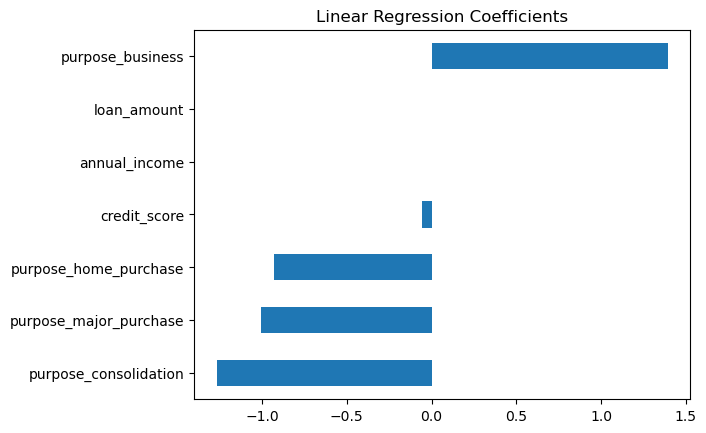

In [16]:
import matplotlib.pyplot as plt
coefficients = model_lr.coef_
coef = pd.DataFrame(data=coefficients, index=X_train.columns,columns=['coefficients'])
coef['coefficients'].sort_values().plot(kind='barh');
plt.title('Linear Regression Coefficients')
plt.show()

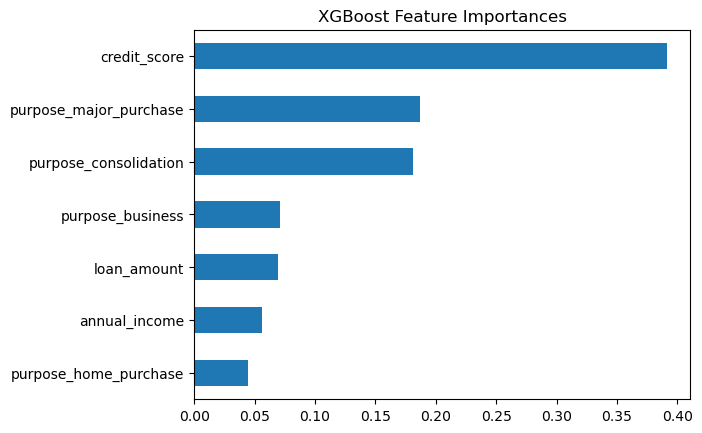

In [17]:
importances = model_xgb.feature_importances_
imp = pd.DataFrame(data=importances, index=X_train.columns, columns=['coefficients'])
imp['coefficients'].sort_values().plot(kind='barh')
plt.title('XGBoost Feature Importances')
plt.show()

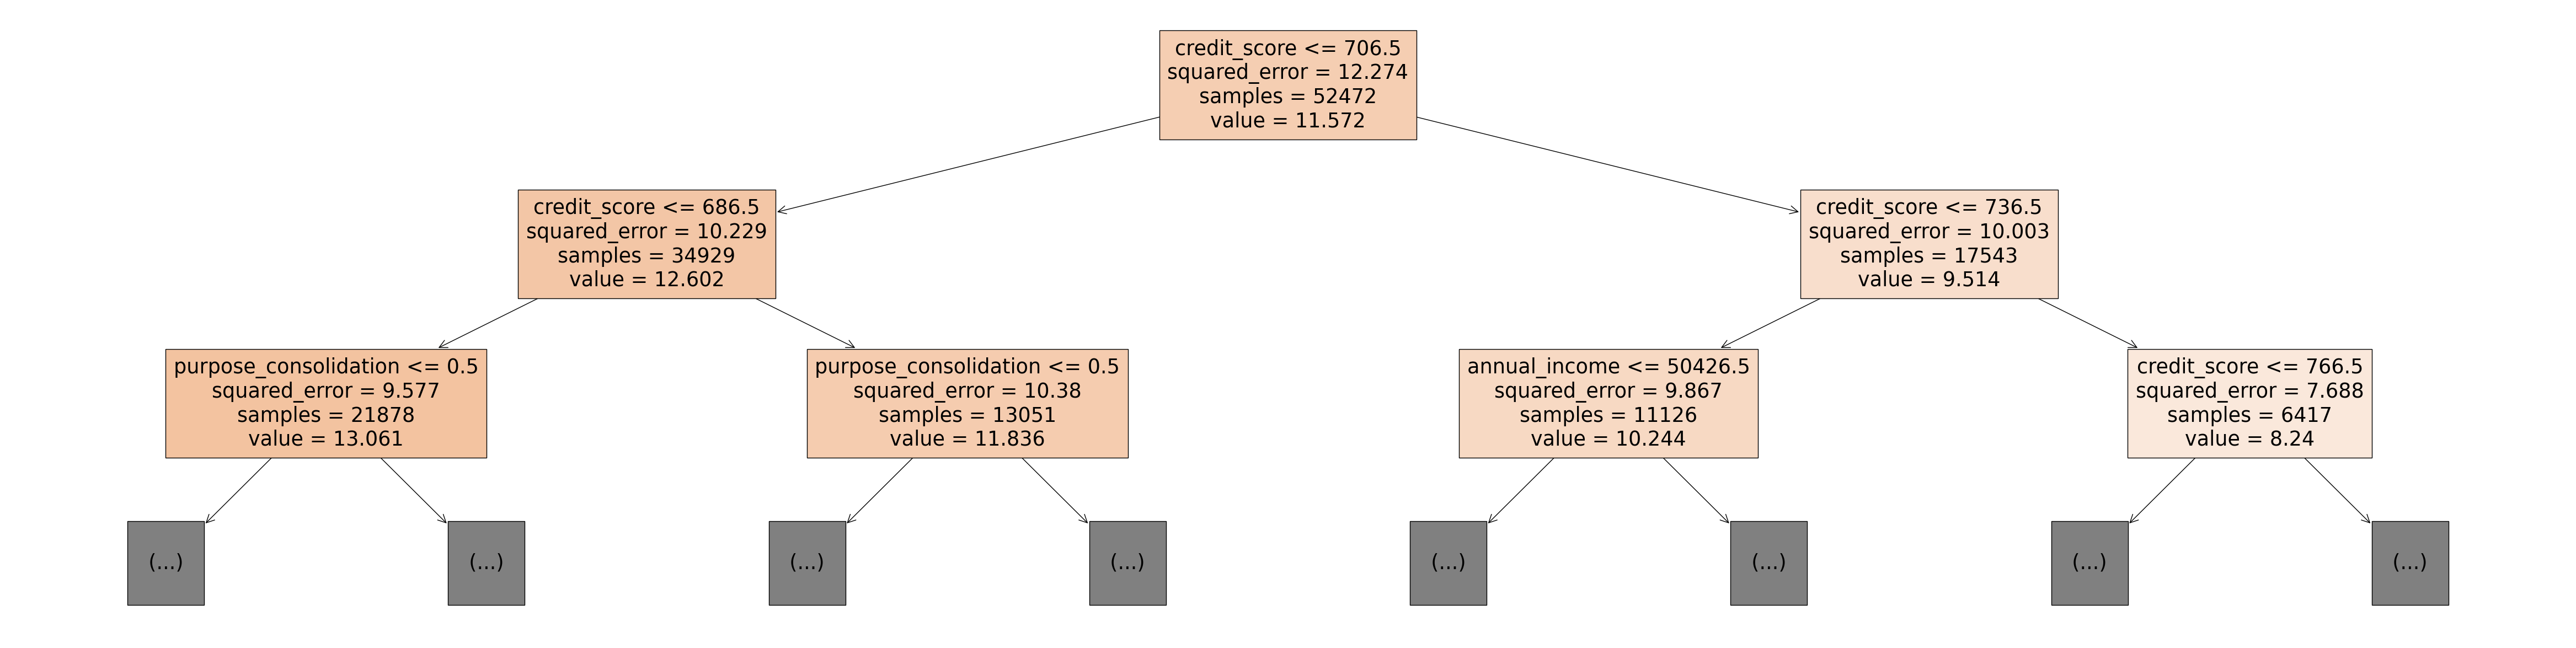

In [18]:
from sklearn.tree import plot_tree

plt.figure(figsize=(60,15))

plot_tree(
     model_rf.estimators_[0],
     max_depth=2,
     feature_names=X_train.columns,
     filled=True
);

## Partial Dependence Plots

One Feature

In [19]:
# select one feature
sample_feature = 'annual_income'
X_val.head()

,purpose_business,purpose_consolidation,purpose_home_purchase,purpose_major_purchase,annual_income,loan_amount,credit_score
issue_d,,,,,,,
2019-03-01,0,1,0,0,96000.0,5000.0,674.0
2017-08-01,0,1,0,0,38000.0,7000.0,739.0


In [20]:
# create an instance of PDP Isolate.
# from pdpbox.pdp import PDPIsolate, PDPInteract
# from pdpbox.info_plots import TargetPlot, InteractTargetPlot
# import shap

from pdpbox.pdp import PDPIsolate, PDPInteract
from pdpbox.info_plots import TargetPlot, InteractTargetPlot

X_val = pd.DataFrame(X_val)

pdp_isolate  = PDPIsolate
pdp_plot = TargetPlot
pdp_interact = PDPInteract
pdp_interact_plot = InteractTargetPlot

isolate = pdp_isolate(
        X_val,
        model_xgb,
        model_features=X_val.columns,
        feature = sample_feature,
        feature_name= 'annual_income'
)


AssertionError: only accept pandas DataFrame

In [ ]:
pdp_plot(isolate, feature = sample_feature)

NameError: name 'isolate' is not defined

Two features

In [21]:
# select two features
sample_features = ['annual_inc', 'fio_range_high']

interact = pdp_interact(
    model_xgb,
    X_val,
    model_features  = X_val.columns,
    features = sample_features,
)

TypeError: PDPInteract.__init__() missing 1 required positional argument: 'feature_names'

In [ ]:
# create an instance of PDP Interact.
pdp_interact_plot(interact, plot_type = 'grid', feature_names = sample_features)

## Shapley Plots

In [27]:
#select one sample/observation
sample_row = X_val.tail(1)
sample_row

,purpose_business,purpose_consolidation,purpose_home_purchase,purpose_major_purchase,annual_income,loan_amount,credit_score
issue_d,,,,,,,
2017-08-01,0,1,0,0,38000.0,7000.0,739.0


In [30]:
# Shapley Force Plot
# This may not work well in local notebooks
# you may need to install ipywidgets
import shap

#initialization of java script
shap.initjs()

explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(sample_row)
shap.force_plot(
    base_value = explainer.expected_value,
    shap_values = shap_values,
    features = sample_row
)


